# ABC calibration of $I_\text{to}$ in Nygren model to original dataset.

In [1]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

INFO:myokit:Loading Myokit version 1.28.3


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used for original dataset calibration:
 - Steady-state activation [Shibata1989]
 - Steady-state inactivation [Firek1995]
 - Inactivation time constant [Nygren1998]
 - Recovery time constant [Nygren1998]

In [4]:
from experiments.ito_shibata import shibata_act
from experiments.ito_firek import firek_inact
from experiments.ito_nygren import nygren_inact_kin, nygren_rec

In [5]:
modelfile = 'models/nygren_ito.mmt'

Plot steady-state and time constant functions of original model

In [6]:
from ionchannelABC.visualization import plot_variables

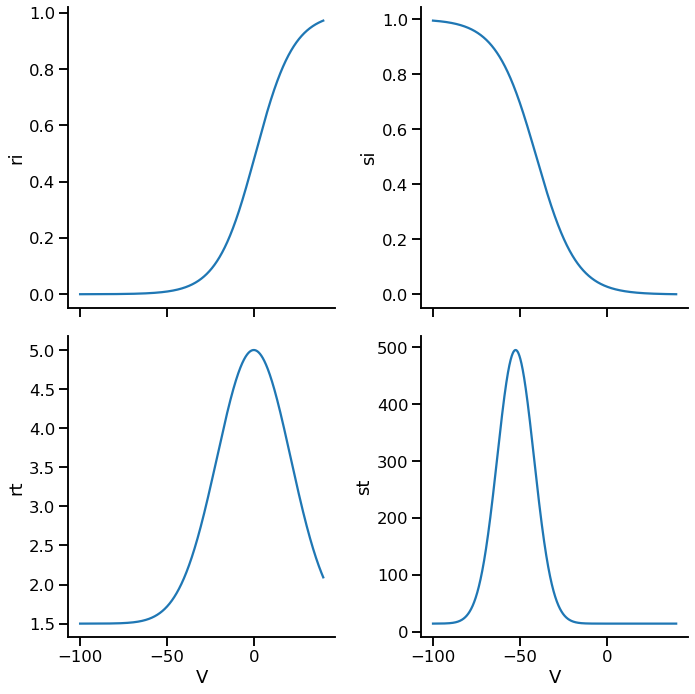

In [7]:
sns.set_context('talk')

V = np.arange(-100, 40, 0.01)

nyg_par_map = {'ri': 'ito.r_inf',
            'si': 'ito.s_inf',
            'rt': 'ito.tau_r',
            'st': 'ito.tau_s'}

f, ax = plot_variables(V, nyg_par_map, modelfile, figshape=(2,2))

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [8]:
observations, model, summary_statistics = setup(modelfile,
                                                shibata_act,
                                                firek_inact,
                                                nygren_inact_kin, 
                                                nygren_rec)

In [9]:
assert len(observations)==len(summary_statistics(model({})))

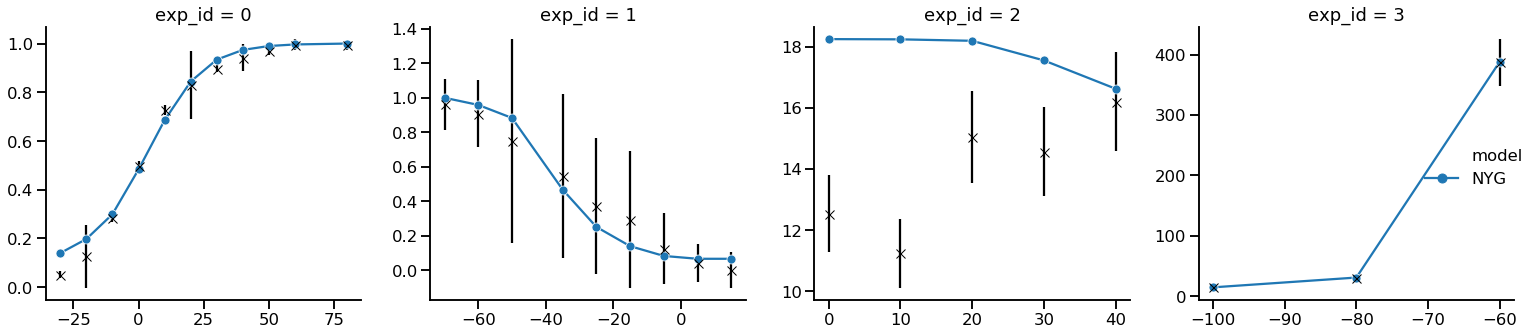

In [10]:
g = plot_sim_results(modelfile,
                     shibata_act,
                     firek_inact,
                     nygren_inact_kin, 
                     nygren_rec)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [11]:
limits = {'ito.p1': (-100, 100),
          'ito.p2': (1e-7, 50),
          'log_ito.p3': (-7, 0),
          'ito.p4': (1e-7, 50),
          'log_ito.p5': (-7, 0),
          'ito.q1': (-100, 100),
          'ito.q2': (1e-7, 50),
          'log_ito.q3': (-5, 1),
          'ito.q4': (-100, 100),
          'ito.q5': (1e-7, 50),
          'log_ito.q6': (-7, 0)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [11]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

## Run ABC-SMC inference

Set-up path to results database.

In [12]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "nygren_ito_original.db"))

In [13]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

Test theoretical number of particles for approximately 2 particles per dimension in the initial sampling of the parameter hyperspace.

In [14]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 2048 particles


Initialise ABCSMC (see pyABC documentation for further details).

IonChannelDistance calculates the weighting applied to each datapoint based on the experimental variance.

In [15]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.0038982367445444, '1': 0.38577745228175364, '2': 1.0038982367445444, '3': 1.0038982367445444, '4': 1.0038982367445444, '5': 0.3572168415098699, '6': 1.0038982367445444, '7': 0.876718530271784, '8': 1.0038982367445444, '9': 1.0038982367445444, '10': 1.0038982367445444, '11': 0.3982203648321785, '12': 0.30108919611853696, '13': 0.0995655690369357, '14': 0.12345526374949933, '15': 0.14874563745352917, '16': 0.1487397907636407, '17': 0.28708664113631527, '18': 0.5367502151514552, '19': 0.5611877527536377, '20': 1.4274479668510263, '21': 1.5920448339927937, '22': 1.1896478441743108, '23': 1.2284316420557255, '24': 1.1042880604189986, '25': 3.6809602013966622, '26': 3.6809602013966622, '27': 1.8404801006983311}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [16]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [17]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-19 09:05:09.567202, end_time=None)>


Run calibration with stopping criterion of particle 1\% acceptance rate.

In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 9054
DEBUG:Epsilon:new eps, t=1, eps=6.650304046339451
INFO:ABC:t:1 eps:6.650304046339451
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 14555
DEBUG:Epsilon:new eps, t=2, eps=3.056480417118762
INFO:ABC:t:2 eps:3.056480417118762
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 21221
DEBUG:Epsilon:new eps, t=3, eps=2.595738898660378
INFO:ABC:t:3 eps:2.595738898660378
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 27964
DEBUG:Epsilon:new eps, t=4, eps=2.348691465655818
INFO:ABC:t:4 eps:2.348691465655818
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 34897
DEBUG:Epsilon:new eps, t=5, eps=2.2253439826899495

## Analysis of results

In [15]:
history = History('sqlite:///results/nygren/ito/original/nygren_ito_original.db')

In [18]:
history.all_runs()

[<ABCSMC(id=1, start_time=2019-10-19 09:05:09.567202, end_time=2019-10-19 14:54:16.651644)>]

In [16]:
df, w = history.get_distribution()

In [17]:
df.describe()

name,ito.p1,ito.p2,ito.p4,ito.q1,ito.q2,ito.q4,ito.q5,log_ito.p3,log_ito.p5,log_ito.q3,log_ito.q6
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.315676,10.527587,24.789505,57.521897,15.675522,56.445687,12.057123,-5.293932,-3.173511,-0.357158,-1.923129
std,1.534572,1.094768,10.920564,16.270882,3.819610,3.532107,2.574997,0.777523,0.887013,0.072899,0.040833
min,-1.556976,6.371610,0.035045,17.296809,2.304544,45.812577,0.752610,-6.994535,-6.997618,-0.480282,-2.049696
25%,2.208411,9.804433,17.319892,45.667043,13.077855,53.958956,10.647988,-5.862693,-3.463503,-0.411733,-1.954141
50%,3.300657,10.493930,24.728692,56.802667,15.892010,56.284107,12.388036,-5.315972,-2.836722,-0.380327,-1.919766
75%,4.339039,11.232769,32.592376,68.682605,18.325041,59.077872,13.789959,-4.757912,-2.586873,-0.318278,-1.885501
max,8.625731,14.869413,49.973058,99.759925,28.095060,65.014029,17.938528,-2.552597,-2.124523,-0.065093,-1.855624


### Plot summary statistics compared to calibrated model output.

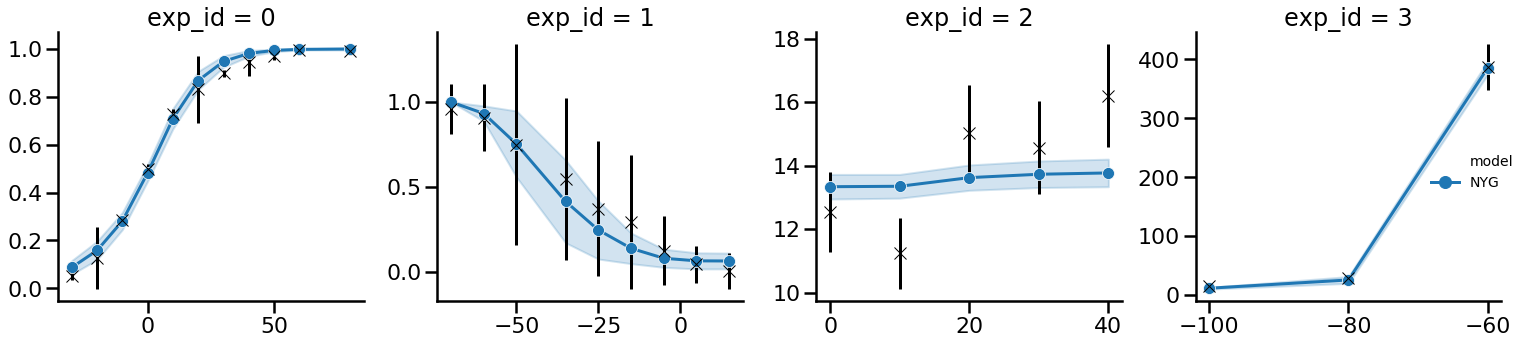

In [19]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     shibata_act,
                     firek_inact,
                     nygren_inact_kin, 
                     nygren_rec,
                     df=df, w=w)

plt.tight_layout()

### Plot gating functions

In [22]:
import pandas as pd
N = 100
nyg_par_samples = df.sample(n=N, weights=w, replace=True)
nyg_par_samples = nyg_par_samples.set_index([pd.Index(range(N))])
nyg_par_samples = nyg_par_samples.to_dict(orient='records')

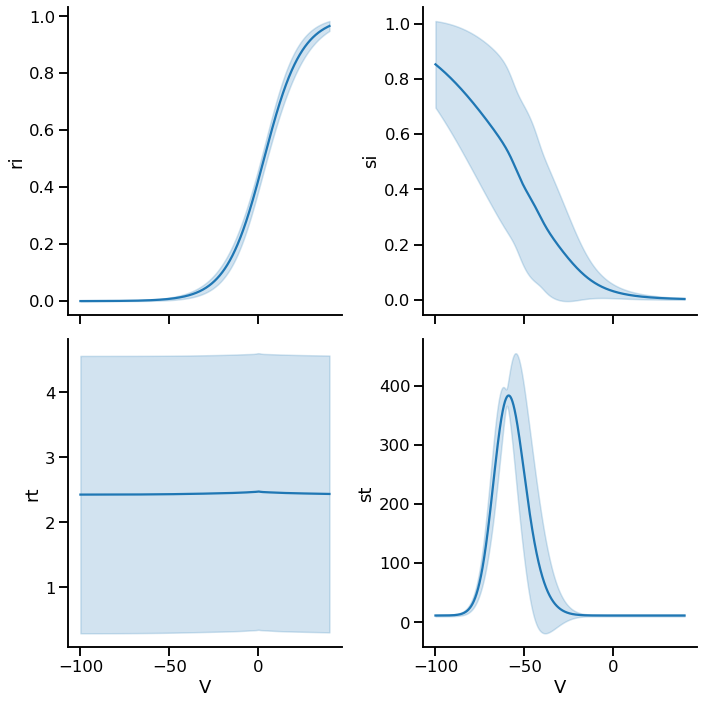

In [25]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, nyg_par_map, 
                       'models/nygren_ito.mmt', 
                       [nyg_par_samples],
                       figshape=(2,2))

plt.tight_layout()

### Plot parameter posteriors

In [27]:
m,_,_ = myokit.load(modelfile)

In [28]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

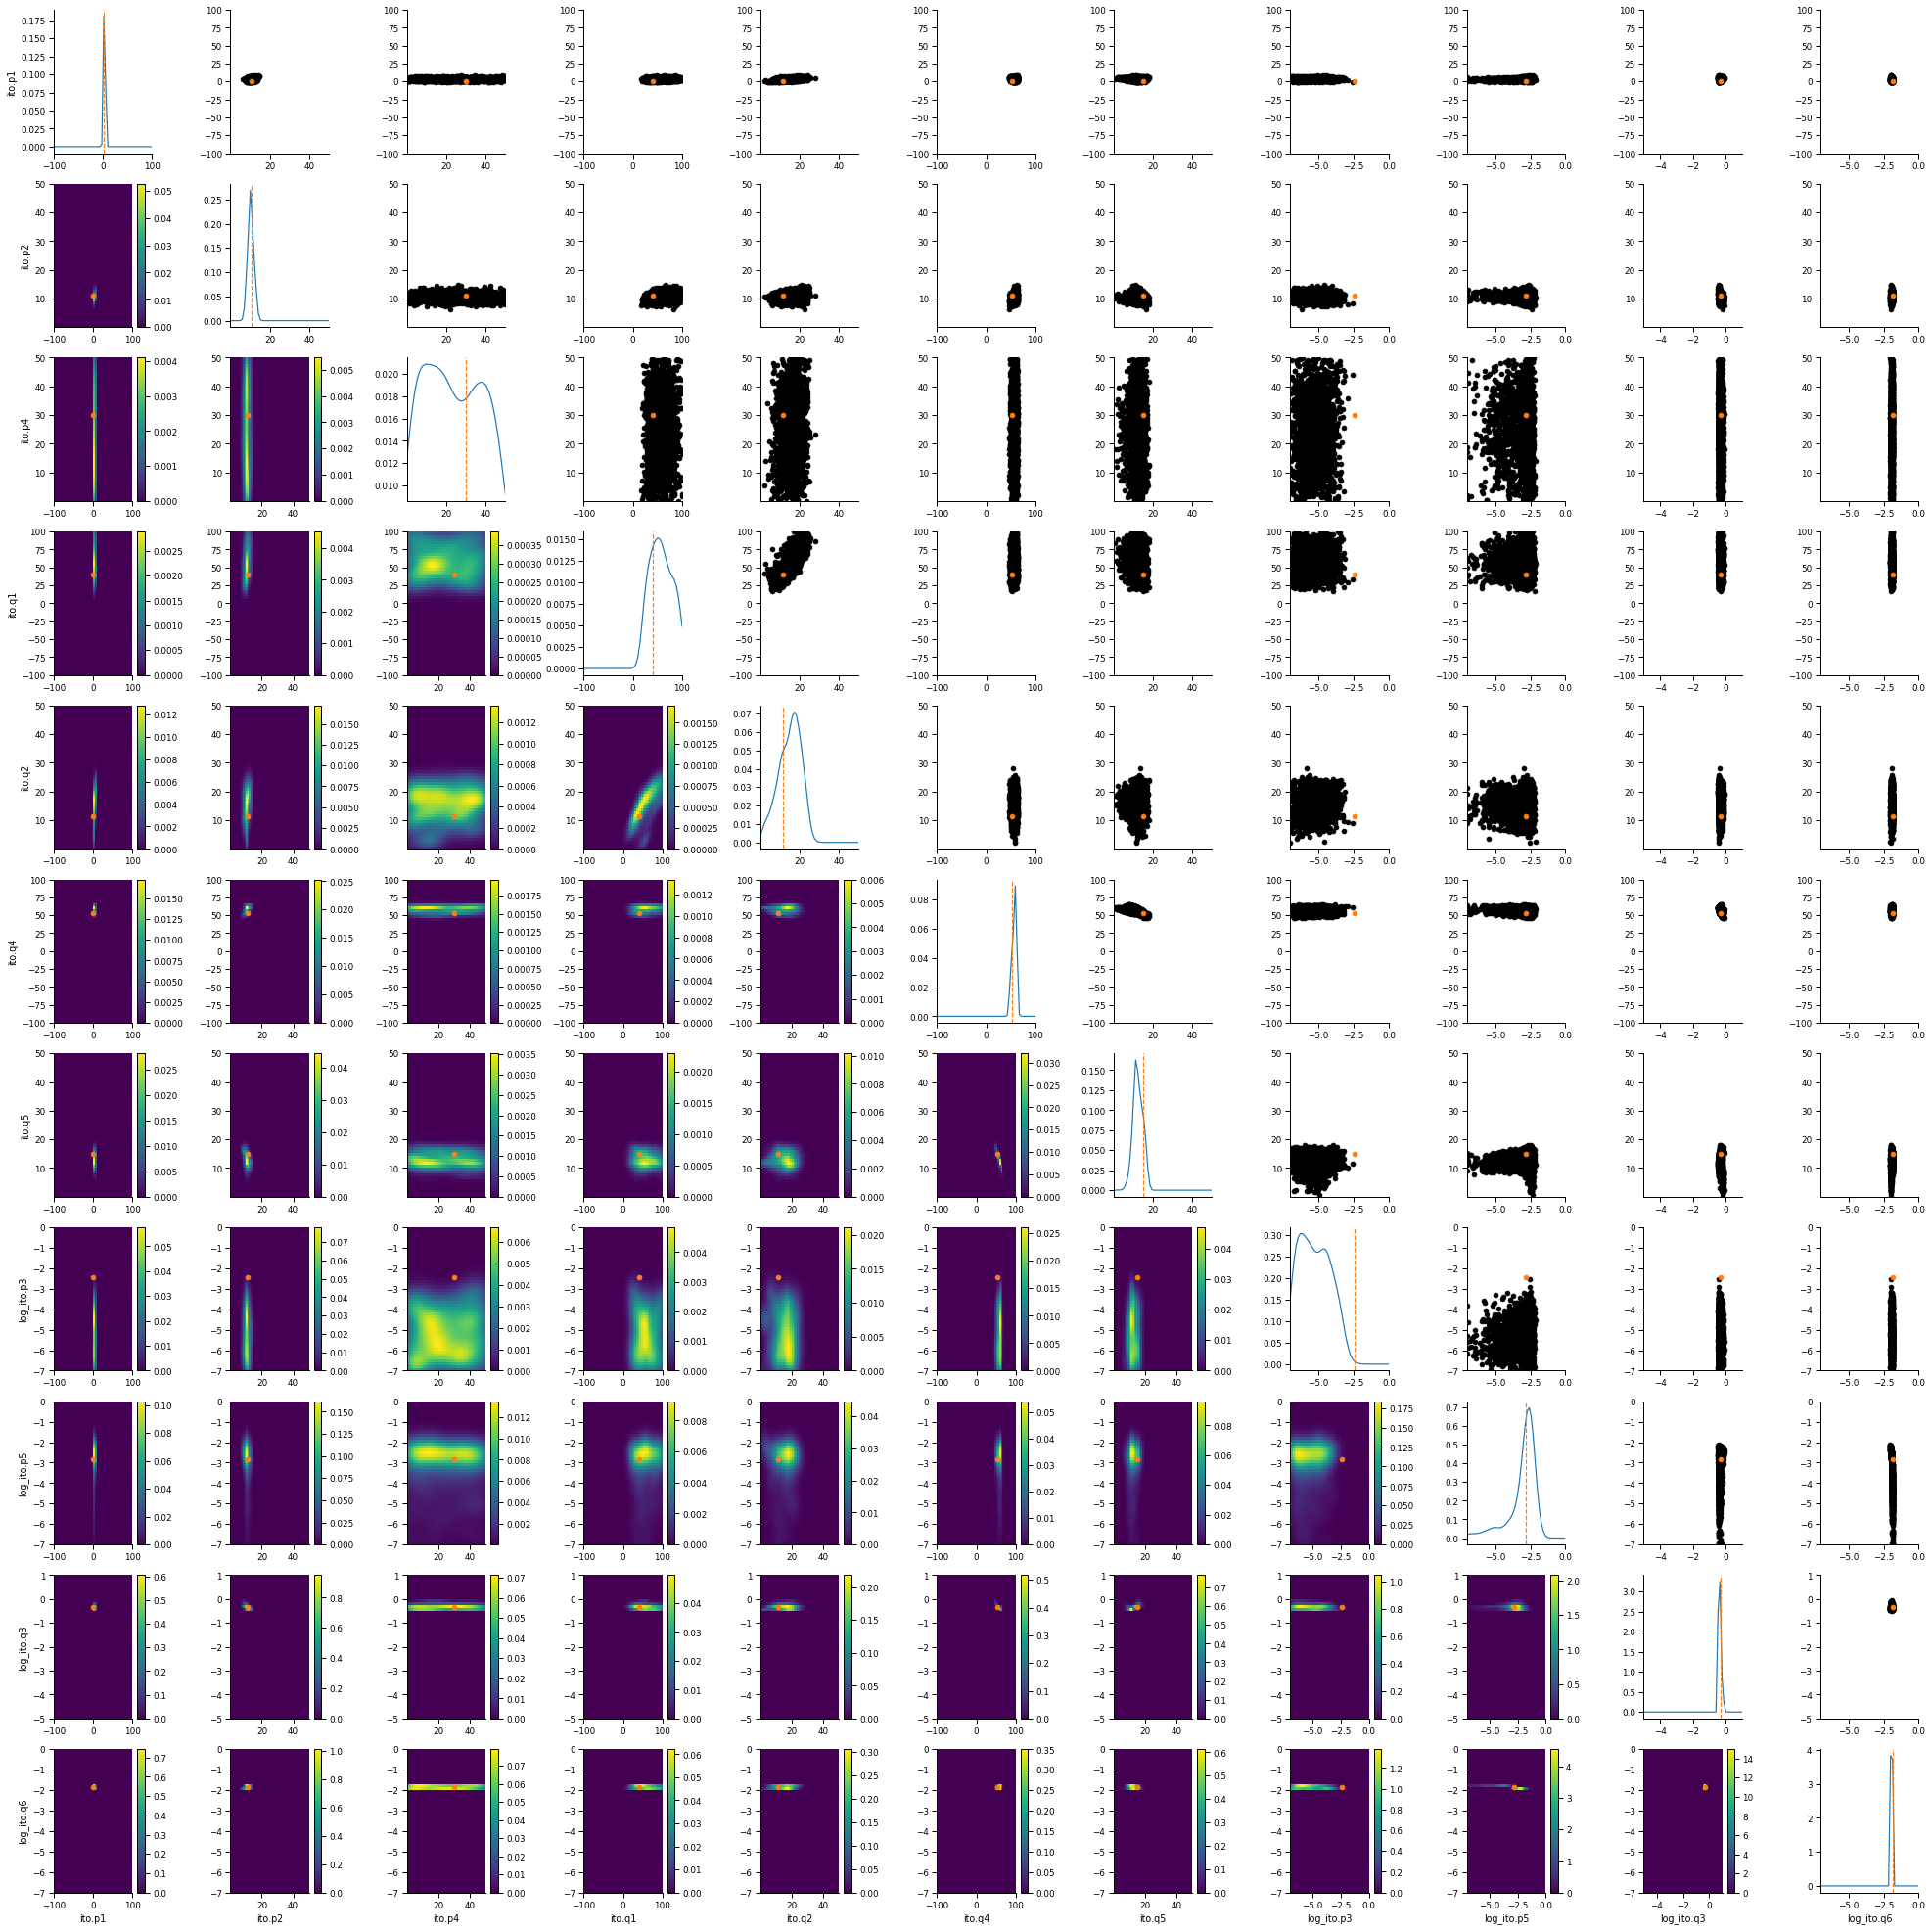

In [30]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

plt.tight_layout()